<a href="https://colab.research.google.com/github/larushba/Space-Odyssey-project/blob/main/Space_Odyssey_A_Travel_in_the_Solar_System_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## $Space\ Odyssey: A\ Travel\ in\ the\ Solar\ System$

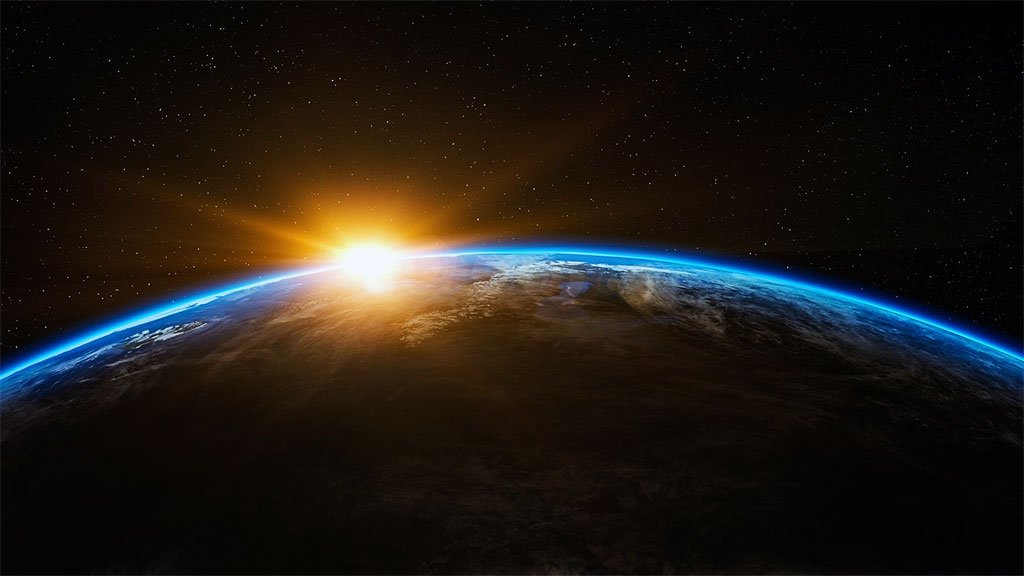

This project is a short exploratory in space using the following APIs:<br>

[NASA API portal](https://api.nasa.gov/)<br>

[SPICE](https://naif.jpl.nasa.gov/naif/) *(Spacecraft Planet Instrument C-matrix Events)*<br>
*An Observation Geometry System for Space Science Missions.<br>
With this tool you can compute trajectories, movements in space and other space dynamic at selected times.* <br>
[SpiceyPy](https://spiceypy.readthedocs.io/en/main/) -
A python wrapper for the SPICE Toolkit.<br>
[James Webb Telescope tracking REST API](https://www.jwst.nasa.gov/content/webbLaunch/whereIsWebb.html)<br><br>

$Now\ we\ are\ ready\ for\ lift-off.$

### $Classes\ \&\ Methods$

In [ ]:
# for metadata files
!git clone https://github.com/larushba/Space-Odyssey-project.git
!pip3 install spiceypy

Cloning into 'Space-Odyssey-project'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 25 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.
     |████████████████████████████████| 1.6 MB 21.6 MB/s 


In [ ]:
from datetime import datetime, timedelta
from IPython.display import Javascript
from pprint import pprint
import spiceypy as spice
import urllib.request
import json
import math
import re

In [ ]:
class Celestial:
    def __init__(self, name, radius, mass, avg_temp, min_temp, max_temp, length_of_year, length_of_day, atmosphere_comp, is_visited):
        self.name = name
        self.radius = radius # km
        self.mass = mass # kg
        self.avg_temp = avg_temp # Celsius
        self.min_temp = min_temp
        self.max_temp = max_temp   
        self.length_of_year = length_of_year # Earth Days
        self.length_of_day = length_of_day # timedelta
        self.atmosphere_comp = atmosphere_comp
        self.is_visited = is_visited  # human/machine
        
        # SPICE uses IDs to identify an object
        self.names_ids = {"Sun": 10,      
                        "Mercury": 199, 
                        "Venus": 299, 
                        "Moon": 301,
                        "Earth": 399,
                        "Mars": 499,
                        "Jupiter": 599,
                        "Titan": 606,
                        "Saturn": 699,
                        "Uranus": 799,
                        "Neptun": 899,
                        "Pluto": 999}


    def __str__(self):
        return (f'Name: {self.name}\nRadius: {self.radius} km\n\
Mass: {self.mass} kg\nAverage temperature: {self.avg_temp} degrees Celsius\n\
Min temperature: {self.min_temp} degrees Celsius\nMax temperature: {self.max_temp} degrees Celsius\n\
Length of year: {self.length_of_year}\nLength of day (in earth\'s days): {self.length_of_day}\n\
Atmosphere composition: {self.atmosphere_comp}\n')


    # NASA requires the Ephemeris Time (ET)
    def conv_today_utc_to_et(self):
        today = datetime.today().strftime('%Y-%m-%dT00:00:00')
        #load dependencies
        spice.furnsh('/content/Space-Odyssey-project/_kernels/lsk/naif0012.tls')
        today_et = spice.utc2et(today) # utc2et
        return today_et


    # Compute the geometric state (position (km) and velocity (km/s)) 
    # of a target body relative to an observing body and the light time
    # between 2 objects
    def compute_state(self, relative_to, et_units):      
        # load dependencies
        spice.furnsh('/content/Space-Odyssey-project/_kernels/spk/de432s.bsp')
        targ_id = self.names_ids[self.name]
        obs_id = self.names_ids[relative_to.name]
        
        # spice.spkgeo returns a tuple of ndarry and a float
        # ndarray with 6 values:
        # first 3 values are the position components
        # last 3 values are the velocity components
        state, light_time = spice.spkgeo(targ=targ_id, \
                            et=et_units, \
                            ref='ECLIPJ2000', \
                            obs=obs_id)
        return state, light_time


    def compute_distance(self, target):  
        et_units = self.conv_today_utc_to_et()
        state, light_time = self.compute_state(target, et_units)
        distance = math.sqrt(state[0]**2.0 \
                            + state[1]**2.0 \
                            + state[2]**2.0)      
        return distance


    # convert distance to astronomical units (1 AU)
    def convert_km_to_au(self, distance): 
        return spice.convrt(distance, "km", "AU")


    def compute_orbital_speed(self, orbited_object):
        et_units = self.conv_today_utc_to_et()
        state, light_time = self.compute_state(orbited_object, et_units)
        speed = math.sqrt(state[3]**2.0 \
                        + state[4]**2.0 \
                        + state[5]**2.0)  
        return speed

In [ ]:
class Planet(Celestial):
    def __init__(self, name, radius, mass, avg_temp, min_temp, max_temp, length_of_year, length_of_day, atmosphere_comp, num_of_moons, is_visited):
        super().__init__(name, radius, mass, avg_temp, min_temp, max_temp, length_of_year, length_of_day, atmosphere_comp, is_visited)
        self.num_of_moons = num_of_moons
   
   
    def __str__(self):
        planet_data = f'Number of moons: {self.num_of_moons}\n\
Was visited by humans/machines: {self.is_visited}'
        return super().__str__() + planet_data

In [ ]:
class Moon(Celestial): 
    def __init__(self, name, radius, mass, avg_temp, min_temp, max_temp, length_of_year, length_of_day, atmosphere_comp, is_visited, orbited_planet):
        super().__init__(name, radius, mass, avg_temp, min_temp, max_temp, length_of_year, length_of_day, atmosphere_comp, is_visited)     
        self.orbited_planet = orbited_planet
        # self.dist_from_orbited_planet


    def __str__(self):
        moon_data = f"Orbited planet: {self.orbited_planet}\n\
Was visited by humans/machines: {self.is_visited}"
        return super().__str__() + moon_data

In [ ]:
class Star(Celestial):
    def __init__(self, name, radius, mass, avg_temp, min_temp, max_temp, length_of_year, length_of_day, atmosphere_comp, is_visited, gravity):
        super().__init__(name, radius, mass, avg_temp, min_temp, max_temp, length_of_year, length_of_day, atmosphere_comp, is_visited)
        self.gravity = gravity # m/s²


    def __str__(self):
        return super().__str__() + f"Gravity: {self.gravity}"

In [ ]:
# narrator
class Robot:
    def __init__(self, name):
        self.name = name
        self.api_key = "qrd6fzz45Kk47c31TPNfZOQLiUuEYr8v4CitjaDC"


    def get_nasa_pic_of_the_Day(self, api_key):
        url = "https://api.nasa.gov/planetary/apod?api_key="
        pic_url_obj = urllib.request.urlopen(url + api_key)  # call webserver
        pic_read = pic_url_obj.read()
        pic_data = json.loads(pic_read.decode("utf-8"))  # decode json to python
        return pic_data


    def explain_picture(self, pic_data):
        print(f"NASA's Picture of the Day for {pic_data['date']} is:\n{pic_data['title']}\n")
        pprint(pic_data['explanation'])


    def open_url(self, url):
        display(Javascript('window.open("{url}");'.format(url=url)))


    def explain_time(self):
        today = datetime.today().strftime('%Y-%m-%dT00:00:00')
        print(f"NASA requires the Ephemeris Time (ET).\n\
It is used to calculate the future positions of the sun and the planets.\n\
Today {today} in ET units is:", end=" ")
    
    
    def create_earth(self):
        earth_length_of_day = timedelta(hours=23, minutes=56)
        earth_atmosphere_comp_perc = {"Nitrogen": 78.08, "Oxygen": 20.95, "Argon": 0.93, "Carbon dioxide": 0.04}
        earth = Planet("Earth", 6371, 5.9722*(10**24), 15, -128.6, 56.7, 365.25, earth_length_of_day, earth_atmosphere_comp_perc, 1, True)
        return earth


    def create_moon(self):  
        moon_length_of_day = timedelta(days=29, hours=12)
        moon_atmosphere_comp_perc = {"Neon": 33.33, "Helium": 33.33, "Argon": 0.93, "Hydrogen": 33.33}
        # avg temp is avg of both sides of the moon, dark and sunlit
        moon = Moon("Moon", 1737.4, 7.3476*(10**22), -38.5, -233, 123, 365.25, moon_length_of_day, moon_atmosphere_comp_perc, True, "Earth")
        return moon


    def create_mars(self):
        mars_length_of_day = timedelta(hours=24, minutes=37)
        mars_atmosphere_comp_perc = {"carbon dioxide": 95, "nitrogen": 3, "argon": 1.6}
        mars = Planet("Mars", 3389.5, 6.39*(10**23), -60, -125, 20, 687, mars_length_of_day, mars_atmosphere_comp_perc, 2, True)
        return mars


    def create_sun(self):
        sun_length_of_day = timedelta(0)
        sun_atmosphere_comp_perc = {"Hydrogen": 73, "Helium": 25}
        sun = Star("Sun", 696340, 1.989*(10**30), 1999726.85, 4000, 15000000, 0, sun_length_of_day, sun_atmosphere_comp_perc, False, 274)
        return sun
        

    def heaviest_to_lightest(self, space_objects):
        sort_masses = sorted(space_objects, key=lambda x: x.mass, reverse=True)
        return list(map(lambda x: (x.name, x.mass), sort_masses))


    def largest_to_smallest(self, space_objects):
        sort_radius = sorted(space_objects, key=lambda x: x.radius, reverse=True)
        return list(map(lambda x: (x.name, x.radius), sort_radius))


    def hottest_to_coldest(self, space_objects):
        sorted_radius = sorted(space_objects, key=lambda x: x.avg_temp, reverse=True)
        return list(map(lambda x: (x.name, x.avg_temp), sorted_radius))


    def have_moons(self, space_objects):
        have_moons = [(obj.name, obj.num_of_moons) for obj in space_objects if isinstance(obj, Planet) and obj.num_of_moons > 0]
        return sorted(have_moons, reverse=True)


    def is_visited(self, space_objects):
        return [obj.name for obj in list(filter(lambda x: x.is_visited, space_objects))]


    def lowest_temp_detected(self, space_objects):
        return min([(obj.min_temp, obj.name) for obj in space_objects])


    def highest_temp_detected(self, space_objects):
        return max([(obj.max_temp, obj.name) for obj in space_objects])


    def closest_to_sun(self, space_objects):
        return sorted([(obj.name, obj.compute_distance(sun)) for obj in space_objects], reverse=True)

    
    # retrieve data from James Webb Space Telescope (jwst)
    def get_jwst_data(self):
        url = "https://api.jwst-hub.com/track"
        data_raw = urllib.request.urlopen(url)
        data = data_raw.read()
        data = json.loads(data.decode("utf-8"))
        
        parsed_data = self.__parse_data(data)
        self.__print_data(parsed_data)


    def __parse_data(self, data):
        headers = []
        for header in data.keys():
            if re.search('([A-Z].*)', header) != None:
                match = re.match('([a-z]+)', header)
                first_word = match.group().capitalize()          
                current_header = re.findall('[A-Z][^A-Z]*', header)
                current_header.insert(0, first_word)
                headers.append(current_header)    
        
        # fix url
        headers[5][2] = headers[5][2] + headers[5][3] + headers[5][4]
        # delete last 2 cells
        del headers[5][4]
        del headers[5][3] 
        
        headers = [" ".join(header) for header in headers]
        parsed_data = [(header, value) for header, value in zip(headers, data.values())]
        return parsed_data


    def __print_data(self, parsed_data):
        today = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
        print(f"James Webb Space Telescope Live Data: {today}")
        print("**********************************************")
        str_data = ""
        for line in parsed_data:
            print(f"{line[0]}: {line[1]}")
        deployed_status = parsed_data[6][1]
        print('\n\033[1m' + deployed_status)  

### $Let's\ explore$

$NASA's\ picture\ of\ the\ day$

In [ ]:
astro = Robot("astro_boy")

In [ ]:
pic_data = astro.get_nasa_pic_of_the_Day(astro.api_key)
astro.explain_picture(pic_data)

NASA's Picture of the Day for 2022-01-14 is:
NGC 1566: The Spanish Dancer Spiral Galaxy

('An island universe of billions of stars, NGC 1566 lies about 60 million '
 'light-years away in the southern constellation Dorado. Popularly known as '
 "the Spanish Dancer galaxy, it's seen face-on from our Milky Way perspective. "
 "A gorgeous grand design spiral, this galaxy's two graceful spiral arms span "
 'over 100,000 light-years, traced by bright blue star clusters, pinkish '
 "starforming regions, and swirling cosmic dust lanes. NGC 1566's flaring "
 'center makes the spiral one of the closest and brightest Seyfert galaxies. '
 'It likely houses a central supermassive black hole wreaking havoc on '
 'surrounding stars, gas, and dust. In this sharp southern galaxy portrait, '
 'the spiky stars lie well within the Milky Way.')


In [ ]:
astro.open_url(pic_data['url'])

<IPython.core.display.Javascript object>

### $Create\ celestials$

In [ ]:
# example of base class
celestial = Celestial("some astroid", 300, 500, 0, -100, 100, 365, 1, {"Nitrogen": 78.08, "Oxygen": 20.95}, False)
print(celestial)

Name: some astroid
Radius: 300 km
Mass: 500 kg
Average temperature: 0 degrees Celsius
Min temperature: -100 degrees Celsius
Max temperature: 100 degrees Celsius
Length of year: 365
Length of day (in earth's days): 1
Atmosphere composition: {'Nitrogen': 78.08, 'Oxygen': 20.95}



In [ ]:
astro.explain_time()
today_in_et = celestial.conv_today_utc_to_et() 
print(today_in_et)

NASA requires the Ephemeris Time (ET).
It is used to calculate the future positions of the sun and the planets.
Today 2022-01-14T00:00:00 in ET units is: 695390469.1842963


In [ ]:
earth = astro.create_earth()
print(earth)

Name: Earth
Radius: 6371 km
Mass: 5.9722e+24 kg
Average temperature: 15 degrees Celsius
Min temperature: -128.6 degrees Celsius
Max temperature: 56.7 degrees Celsius
Length of year: 365.25
Length of day (in earth's days): 23:56:00
Atmosphere composition: {'Nitrogen': 78.08, 'Oxygen': 20.95, 'Argon': 0.93, 'Carbon dioxide': 0.04}
Number of moons: 1
Was visited by humans/machines: True


In [ ]:
moon = astro.create_moon()
print(moon)

Name: Moon
Radius: 1737.4 km
Mass: 7.3476e+22 kg
Average temperature: -38.5 degrees Celsius
Min temperature: -233 degrees Celsius
Max temperature: 123 degrees Celsius
Length of year: 365.25
Length of day (in earth's days): 29 days, 12:00:00
Atmosphere composition: {'Neon': 33.33, 'Helium': 33.33, 'Argon': 0.93, 'Hydrogen': 33.33}
Orbited planet: Earth
Was visited by humans/machines: True


In [ ]:
mars = astro.create_mars()
print(mars)

Name: Mars
Radius: 3389.5 km
Mass: 6.39e+23 kg
Average temperature: -60 degrees Celsius
Min temperature: -125 degrees Celsius
Max temperature: 20 degrees Celsius
Length of year: 687
Length of day (in earth's days): 1 day, 0:37:00
Atmosphere composition: {'carbon dioxide': 95, 'nitrogen': 3, 'argon': 1.6}
Number of moons: 2
Was visited by humans/machines: True


In [ ]:
sun = astro.create_sun()
print(sun)

Name: Sun
Radius: 696340 km
Mass: 1.9890000000000002e+30 kg
Average temperature: 1999726.85 degrees Celsius
Min temperature: 4000 degrees Celsius
Max temperature: 15000000 degrees Celsius
Length of year: 0
Length of day (in earth's days): 0:00:00
Atmosphere composition: {'Hydrogen': 73, 'Helium': 25}
Gravity: 274


#### $Compute\ position,\ velocity,\ light time$<br>

In [ ]:
today = datetime.today().strftime('%Y-%m-%dT00:00:00')

In [ ]:
state, light_time = moon.compute_state(earth, today_in_et)

print(f'State vector (position and velocity) of {moon.name} relative to {earth.name} for {today} (midnight):\n\
position: {state[:3]}\nvelocity: {state[3:]}\nlight time: {light_time:.4f}')

State vector (position and velocity) of Moon relative to Earth for 2022-01-14T00:00:00 (midnight):
position: [139210.18094517 381054.08473787   6092.27477483]
velocity: [-0.9049386   0.33382183  0.08535176]
light time: 1.3534


In [ ]:
state, light_time = earth.compute_state(moon, today_in_et)

print(f'State vector (position and velocity) of {earth.name} relative to {moon.name} for {today} (midnight):\n\
position: {state[:3]}\nvelocity: {state[3:]}\nlight time: {light_time:.4f}')

State vector (position and velocity) of Earth relative to Moon for 2022-01-14T00:00:00 (midnight):
position: [-139210.18094517 -381054.08473787   -6092.27477483]
velocity: [ 0.9049386  -0.33382183 -0.08535176]
light time: 1.3534


In [ ]:
state, light_time = sun.compute_state(earth, today_in_et)

print(f'State vector (position and velocity) of {moon.name} relative to {earth.name} for {today} (midnight):\n\
position: {state[:3]}\nvelocity: {state[3:]}\nlight time: {light_time:.4f}')

State vector (position and velocity) of Moon relative to Earth for 2022-01-14T00:00:00 (midnight):
position: [ 5.86263963e+07 -1.34952202e+08  6.38795689e+03]
velocity: [2.77954522e+01 1.19859186e+01 3.37389689e-04]
light time: 490.7946


In [ ]:
state, light_time = earth.compute_state(sun, today_in_et)

print(f'State vector (position and velocity) of {moon.name} relative to {earth.name} for {today} (midnight):\n\
position: {state[:3]}\nvelocity: {state[3:]}\nlight time: {light_time:.4f}')

State vector (position and velocity) of Moon relative to Earth for 2022-01-14T00:00:00 (midnight):
position: [-5.86263963e+07  1.34952202e+08 -6.38795689e+03]
velocity: [-2.77954522e+01 -1.19859186e+01 -3.37389689e-04]
light time: 490.7946


#### When Insufficient data exists, an error will be raised:



In [ ]:
try:
    state, light_time = earth.compute_state(mars, today_in_et) 
    today = datetime.today().strftime('%Y-%m-%dT00:00:00')
    print(f'State vector (position and velocity) of {earth.name} relative to {mars.name} for {today} (midnight):\n\
position: {state[:3]}\nvelocity: {state[3:]}\nlight time: {light_time:.4f}')
except Exception as e:
    print(e)



Toolkit version: CSPICE66

SPICE(SPKINSUFFDATA) --

Insufficient ephemeris data has been loaded to compute the state of 399 (EARTH) relative to 499 (MARS) at the ephemeris epoch 2022 JAN 14 00:01:09.184.

spkgeo_c --> SPKGEO



#### $Compute\ distances$

In [ ]:
dist = moon.compute_distance(earth)
print(f'Current distance between the Earth and the Moon in km: {dist:,.2f} km')

dist_au = moon.convert_km_to_au(dist)
print(f'Current distance between the Earth and the Moon in AU: {dist_au:.4f}')

Current distance between the Earth and the Moon in km: 405,732.43 km
Current distance between the Earth and the Moon in AU: 0.0027


In [ ]:
dist = earth.compute_distance(sun)
print(f'Current distance between the Earth and the sun in km: {dist:,.2f} km')

dist_au = earth.convert_km_to_au(dist)
print(f'Current distance between the Earth and the Sun in AU: {dist_au:.4f}')
print("It should be around 1 astronomical unit (1 AU), which is roughly the distance from Earth to the Sun!")

Current distance between the Earth and the sun in km: 147,136,505.76 km
Current distance between the Earth and the Sun in AU: 0.9835
It should be around 1 astronomical unit (1 AU), which is roughly the distance from Earth to the Sun!


Still Insufficient ephemeris data for mars:

In [ ]:
try:
    dist = earth.compute_distance(mars)
    print(f'Current distance between the Earth and Mars in km: {dist:,.2f} km')

    dist_au = mars.convert_km_to_au(dist)
    print(f'Current distance between the Earth and Mars in AU: {dist_au:.4f}')
except Exception as e:
    print(e)



Toolkit version: CSPICE66

SPICE(SPKINSUFFDATA) --

Insufficient ephemeris data has been loaded to compute the state of 399 (EARTH) relative to 499 (MARS) at the ephemeris epoch 2022 JAN 14 00:01:09.184.

spkgeo_c --> SPKGEO



#### $Compute\ orbital\ speed:$

In [ ]:
earth_orbital_speed = earth.compute_orbital_speed(sun)
print(f'Earth\'s orbital speed around the Sun is {earth_orbital_speed:.4f} km/s')

Earth's orbital speed around the Sun is 30.2696 km/s


In [ ]:
moon_orbital_speed = moon.compute_orbital_speed(earth)
print(f'The Moon\'s orbital speed around the Earth is {moon_orbital_speed:.4f} km/s')

The Moon's orbital speed around the Earth is 0.9683 km/s


In [ ]:
try:
    mars_orbital_speed = mars.compute_orbital_speed(sun)
    print(f'Mars\' orbital speed around the Sun is {mars_orbital_speed:.4f} km/s')
except Exception as e:
    print(e)



Toolkit version: CSPICE66

SPICE(SPKINSUFFDATA) --

Insufficient ephemeris data has been loaded to compute the state of 499 (MARS) relative to 10 (SUN) at the ephemeris epoch 2022 JAN 14 00:01:09.184.

spkgeo_c --> SPKGEO



#### $Let's\ sort\ and\ compare$

In [ ]:
# create all planets and add to list
space_objects = [sun, earth, moon, mars]

print("By Mass (descending):")
pprint(astro.heaviest_to_lightest(space_objects))

By Mass (descending):
[('Sun', 1.9890000000000002e+30),
 ('Earth', 5.9722e+24),
 ('Mars', 6.39e+23),
 ('Moon', 7.3476e+22)]


In [ ]:
print("By Radius (descending):")
pprint(astro.largest_to_smallest(space_objects))

By Radius (descending):
[('Sun', 696340), ('Earth', 6371), ('Mars', 3389.5), ('Moon', 1737.4)]


In [ ]:
print("By temperature (descending):")
pprint(astro.hottest_to_coldest(space_objects))

By temperature (descending):
[('Sun', 1999726.85), ('Earth', 15), ('Moon', -38.5), ('Mars', -60)]


In [ ]:
print("Space objects which have moons:")
print(astro.have_moons(space_objects))

Space objects which have moons:
[('Mars', 2), ('Earth', 1)]


In [ ]:
print("Space objects which have been visited by machine or humans:")
print(astro.is_visited(space_objects))

Space objects which have been visited by machine or humans:
['Earth', 'Moon', 'Mars']


In [ ]:
print("Lowest temperature detected in a space object:")
print(astro.lowest_temp_detected(space_objects))

Lowest temperature detected in a space object:
(-233, 'Moon')


In [ ]:
print("Highest temperature detected in a space object:")
print(astro.highest_temp_detected(space_objects))

Highest temperature detected in a space object:
(15000000, 'Sun')


In [ ]:
# space_objects = [sun, earth, moon]
# print("Closest objects to the sun:")
# print(astro.closest_to_sun(space_objects))

#### $For\ a\ finale\ closure,\ let's\ check\ the\ new\ James\ Webb\ Space\ Telescope:$

In [ ]:
jwst_data_today = astro.get_jwst_data()
jwst_data_today

James Webb Space Telescope Live Data: 2022-01-14 19:51:06
**********************************************
Distance Earth Km: 1252662
Launch Elapsed Time: 20:07:31:06
Distance L2 Km: 193669.6
Percentage Completed: 86.6094
Speed Km S: 0.295
Deployment Img URL: https://webb.nasa.gov/content/webbLaunch/assets/images/deployment/1000pxWide/124.png
Current Deployment Step: Individual Mirror Segment Movements - Actuator testing and individual mirror segment deployments
Temp C: {'tempWarmSide1C': 55, 'tempWarmSide2C': 11, 'tempCoolSide1C': -200, 'tempCoolSide2C': -201}

Individual Mirror Segment Movements - Actuator testing and individual mirror segment deployments


$Thank\ you$<br>
$To\ infinity\ and\ beyond$ ⭐

